In [1]:
# Libraries for basic operations
import pandas as pd
import numpy as np
from collections import Counter
import string
import random

# Tqdm for progress bars
from tqdm import tqdm

# Seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch for model building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# BERT Tokenizer for tokenizing
from transformers import BertTokenizer

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# String and NLTK for initial dataset analysis
from nltk import ngrams
import string

In [2]:
!nvidia-smi

Wed Apr 16 01:42:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

In [5]:
# Generating new dataframes for positive and negative classes
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

# Sampling 50,000 rows from each class
df_zero_sampled = df_zero.sample(50000, random_state=1)
df_one_sampled = df_one.sample(50000, random_state=1)

df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(inplace=True)
print(f'Number of rows in data subset: {len(df)}')

Number of rows in data subset: 100000


In [6]:
df.iloc[0]['text']

"Many people have come to believe that the face on Mars was made by aliens. That, however, is wrong. The face on Mars is actually just a mesa. People will say, ¨That´s what the government wants you to think.¨ Those people are obviously ignoring all the logic and facts that say the face is just a normal landform.\n\nFirst, the so called face is just an illusion. It says so in the article. ¨...formed by shadows giving the illusion of eyes, nose, and mouth, ¨ is what the article said. So the face is just a trick of the eye. Those sneaky scientists.\n\nNASA thought this illusion would bring Mars some attention. Which it did. That's my next point. NASA released this face picture, so it would give some attention to NASA and Mars. If this face was made by aliens, I don't think that the government would release that information. Just a thought.\n\nFinally, this land from is similar to those in the Western part of the US. That right there proves everything. Larth was all volcanos at one point. 

In [7]:
!rm -rf ~/.cache/huggingface/transformers/bert-base-uncased

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
tokenizer.save_pretrained("./bert-tokenizer")

('./bert-tokenizer/tokenizer_config.json',
 './bert-tokenizer/special_tokens_map.json',
 './bert-tokenizer/vocab.txt',
 './bert-tokenizer/added_tokens.json')

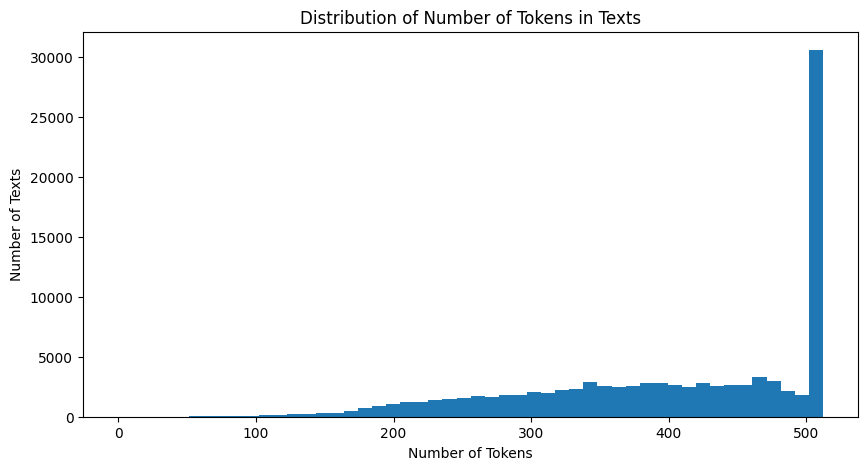

Maximum token length for the tokenizer: 512
Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0


In [10]:
# Load tokenizer from local directory
tokenizer = BertTokenizer.from_pretrained("./bert-tokenizer", local_files_only=True)


# Extracting the maximum length of sequences that the tokenizer can handle
max_length = tokenizer.model_max_length

# Creating a copy of the dataframe for visualization purposes
df_visualization = df.copy()

# Tokenizing the text and calculating the number of tokens in each text
def tokenize_and_truncate(text, max_length):
    tokens = tokenizer.tokenize(text)
    return tokens[:max_length]

df_visualization['tokens'] = df_visualization['text'].apply(lambda x: tokenize_and_truncate(x, max_length))
df_visualization['num_tokens'] = df_visualization['tokens'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df_visualization['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()

print(f'Maximum token length for the tokenizer: {max_length}')
print(f"Maximum number of tokens in a text: {df_visualization['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df_visualization['num_tokens'].quantile(0.95)}")


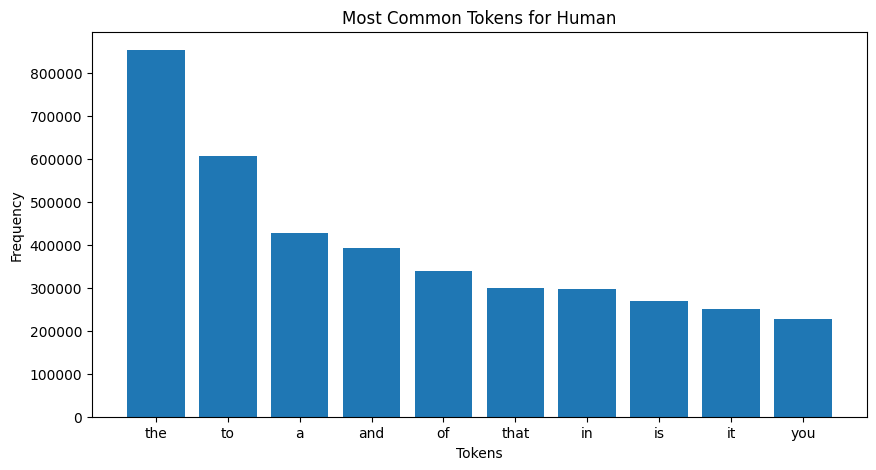

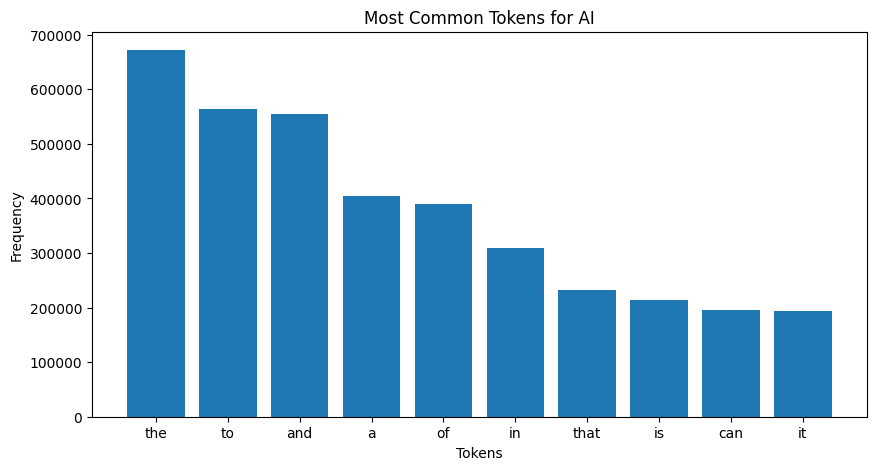

In [11]:
# Function to plot the most common tokens by class
def plot_common_tokens(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    # Filtering out tokens that are punctuation
    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    plt.figure(figsize=(10, 5))
    plt.bar(tokens, counts)
    plt.title(f'Most Common Tokens for {class_map[class_value]}')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

# Plotting for AI and not AI
plot_common_tokens(df_visualization, 0)
plot_common_tokens(df_visualization, 1)


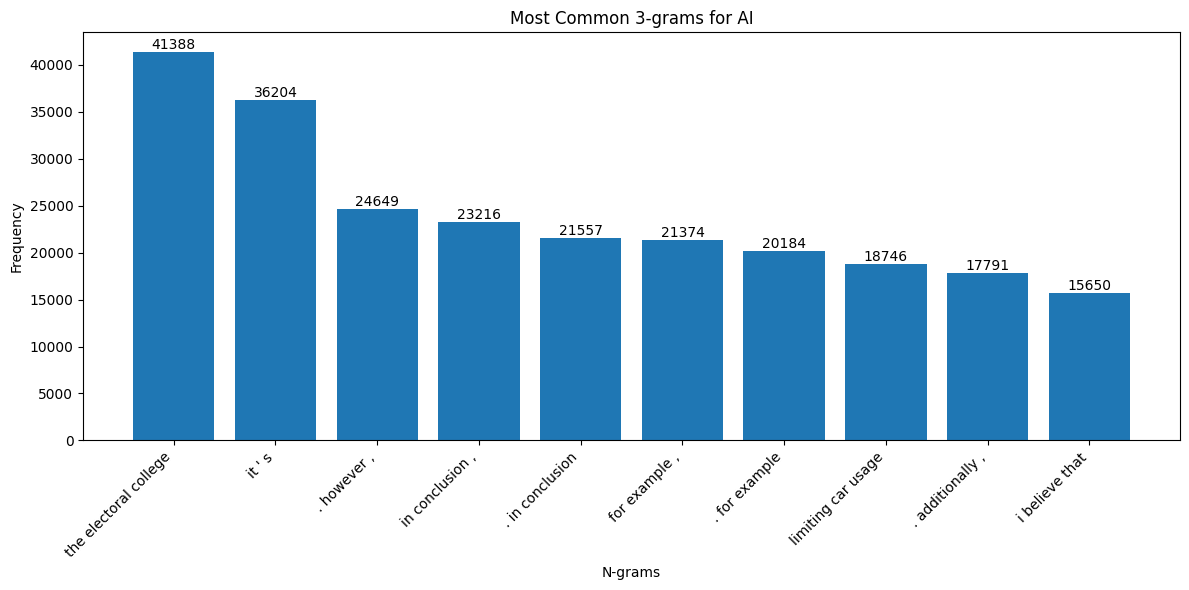

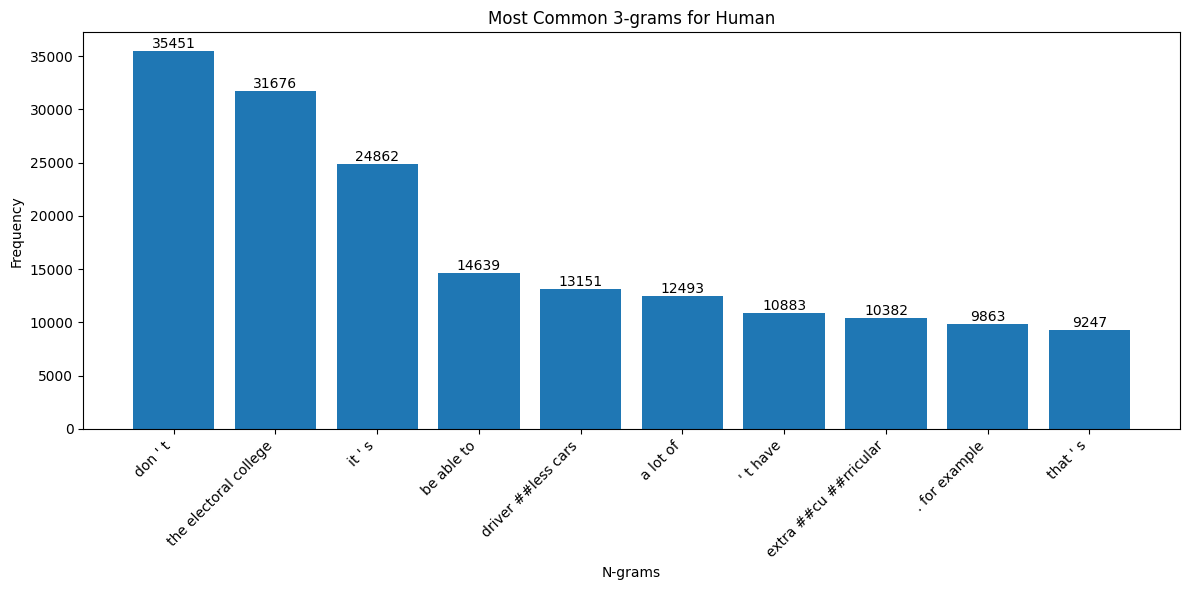

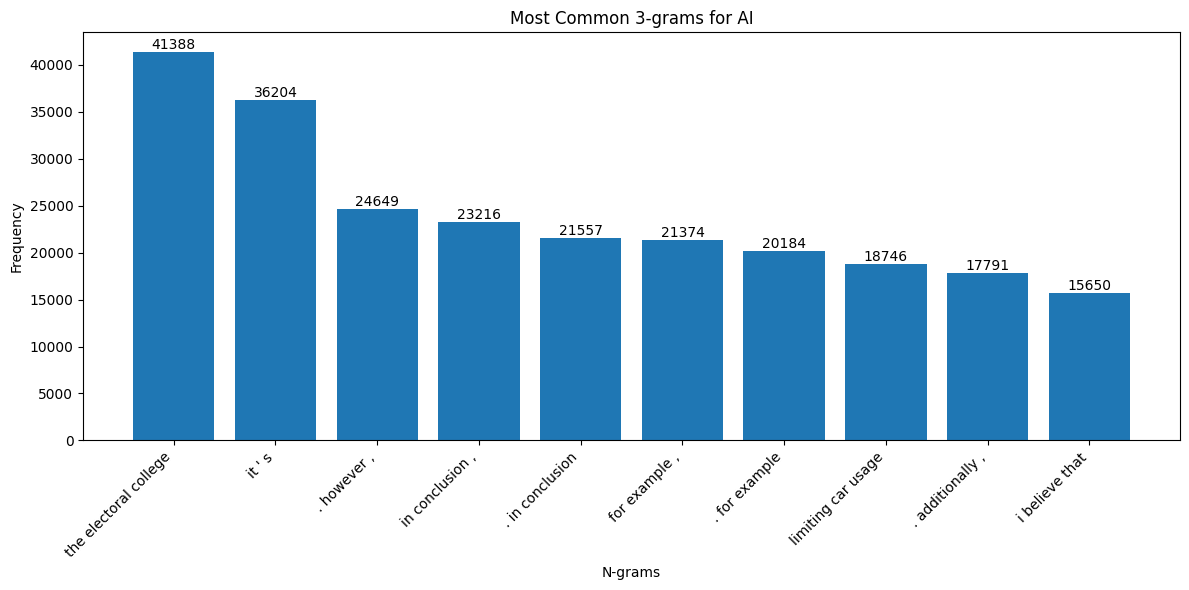

In [12]:
# Function to plot the most common n-grams by class
def plot_common_ngrams(df, class_value, n, figsize=(12, 6)):
    df_class = df[df['generated'] == class_value].copy()
    class_map = {0: 'Human', 1: 'AI'}
    
    if df_class.empty:
        raise ValueError(f"No data found for class {class_map[class_value]}")
    
    # Initializing empty Counter
    ngram_freq = Counter()
    
    # Processing each token sequence
    for tokens in df_class['tokens']:
        # Skip if tokens is None or empty
        if not tokens:
            continue
            
        # Ensure tokens is a list
        if isinstance(tokens, str):
            tokens = tokens.split()
            
        # Generate n-grams only if sequence is long enough
        if len(tokens) >= n:
            try:
                sequence_ngrams = list(ngrams(tokens, n))
                ngram_freq.update(sequence_ngrams)
            except (TypeError, RuntimeError) as e:
                print(f"Warning: Could not generate n-grams for sequence: {tokens[:50]}...")
                continue
    
    if not ngram_freq:
        raise ValueError(f"No valid {n}-grams could be generated for {class_map[class_value]}")
    
    # Most common n-grams
    common_ngrams = ngram_freq.most_common(10)
    if not common_ngrams:
        raise ValueError(f"No common {n}-grams found for {class_map[class_value]}")
    
    # Unzipping the n-grams and counts
    ngrams_, counts = zip(*common_ngrams)
    
    # Creating the plot
    plt.figure(figsize=figsize)
    
    # Creating readable labels by joining n-gram tokens
    labels = [' '.join(ngram) for ngram in ngrams_]
    
    # Plotting bars
    bars = plt.bar(range(len(counts)), counts, align='center')
    
    # Customizing the plot
    plt.title(f'Most Common {n}-grams for {class_map[class_value]}')
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    
    # Setting x-axis labels
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')
    
    # Adding value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    # Adjusting layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

plot_common_ngrams(df_visualization, 0, 3)
plot_common_ngrams(df_visualization, 1, 3)


In [13]:
original_sentence = "Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!"
tokens = tokenizer.tokenize(original_sentence)
input_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original sentence:\n{original_sentence}')
print(f'Tokens:\n{tokens}')
print(f'Input IDs:\n{input_ids}')

Original sentence:
Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!
Tokens:
['hello', ',', 'i', "'", 'm', 'ta', '##avi', '.', 'i', 'love', 'ai', 'and', 'i', "'", 'd', 'love', 'to', 'work', 'at', 'open', '##ai', 'or', 'google', 'deep', '##mind', '!']
Input IDs:
[7592, 1010, 1045, 1005, 1049, 11937, 18891, 1012, 1045, 2293, 9932, 1998, 1045, 1005, 1040, 2293, 2000, 2147, 2012, 2330, 4886, 2030, 8224, 2784, 23356, 999]


In [14]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

In [15]:
# Creating the Dataset
dataset = TextDataset(df, tokenizer, max_length)

In [16]:
def create_data_loaders(dataset, train_prop=0.75, val_prop=0.1, test_prop=0.15, batch_size=100):
    train_len = int(train_prop * len(dataset))
    val_len = int(val_prop * len(dataset))
    test_len = int(test_prop * len(dataset))

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [17]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dimension):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dimension = dimension

        # LSTM layer of size dimension, with one layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layer for outputting the final result
        self.fc = nn.Linear(dimension, 1)

    def forward(self, input_ids, ids_len):
        # Turning words into embeddings
        ids_embedded = self.embedding(input_ids)

        # Packing the sequence of embeddings
        packed_input = pack_padded_sequence(ids_embedded, ids_len, batch_first=True)

        # Processing sequence with LSTM layer
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Extracting the output of the final LSTM unit
        out_forward = output[range(len(output)), ids_len - 1, :self.dimension]

        # Applying dropout for regularization
        ids_dropout = self.dropout(out_forward)

        # Passing through fully connected layer
        ids_fc = self.fc(ids_dropout)

        # Removing unnecessary dimension
        ids_fc = torch.squeeze(ids_fc, 1)

        # Applying sigmoid activation function to get output in range 0-1
        output = torch.sigmoid(ids_fc)

        return output

In [19]:
# Defining model hyperparameters
vocab_size = len(tokenizer.vocab)
dimension = 32
embedding_dim = 100

print(f'Vocab size: {vocab_size}')
model = LSTMClassifier(vocab_size, embedding_dim, dimension)

Vocab size: 30522


In [20]:
def print_model_summary(model):
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params+=param
        print(f'{name}\t{str(list(parameter.shape))}\t{param}')
    print('--------------------')
    print(f'Total Params:{total_params}')

print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 100]	3052200
lstm.weight_ih_l0	[128, 100]	12800
lstm.weight_hh_l0	[128, 32]	4096
lstm.bias_ih_l0	[128]	128
lstm.bias_hh_l0	[128]	128
fc.weight	[1, 32]	32
fc.bias	[1]	1
--------------------
Total Params:3069385


In [21]:
# Train function

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Performing training on all batches for an epoch
        model.train() # Setting model to training mode
        # Initializing progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        # Initializing loss for this epoch
        epoch_train_loss = 0
        for batch in train_progress_bar:
            # Zeroing the gradients
            optimizer.zero_grad()

            # Sorting the lengths of text in descending order and getting the sorted indices
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            # Using the sorted indices to rearrange the ids and targets
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            # Moving ids and targets to the specified device
            # PyTorch expects the lengths tensor to be on the CPU, so we won't move that
            # For some reason, I had to use .cuda() here on Kaggle because .to(device) didn't work like it did on Colab
            ids = ids.cuda()
            targets = targets.cuda()

            # Checking whether the model passed in is an LSTM or CNN, and making predictions accordingly
            if isinstance(model, LSTMClassifier):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids) # CNNClassifier doesn't use the text_lengths parameter

            # Computing loss with the specified criterion
            loss = criterion(predictions, targets)

            # Backward pass: computing gradient of the loss with respect to model parameters
            loss.backward()
            # Performing a single optimization step (parameter update)
            optimizer.step()

            # Updating training loss for epoch
            epoch_train_loss += loss.item()
            # Updating progress bar
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Appending average training loss for epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Performing validation at the end of each epoch
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # No gradient during validation. The rest is very similar to training
            total_loss, total_correct, total_labels = 0, 0, 0
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device)

                if isinstance(model, LSTMClassifier):
                    predictions = model(ids, text_lengths)
                else:
                    predictions = model(ids)

                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += ids.size(0)

            avg_loss = total_loss / total_labels
            avg_acc = total_correct / total_labels

            val_losses.append(avg_loss)
            val_accuracies.append(avg_acc)

            print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

    return train_losses, val_losses, val_accuracies


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
# Defining loss function
criterion = nn.BCELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Moving the model and loss function to same device
model = model.to(device)
criterion = criterion.to(device)

# Defining number of epochs - 4 here to save time
epochs = 4

In [ ]:
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/4: 100%|██████████| 750/750 [10:32<00:00,  1.18batch/s, training_loss=0.191]


Validation Loss: 0.177, Validation Accuracy: 0.948


Epoch 2/4: 100%|██████████| 750/750 [10:27<00:00,  1.20batch/s, training_loss=0.245]


Validation Loss: 0.229, Validation Accuracy: 0.932


Epoch 3/4: 100%|██████████| 750/750 [10:31<00:00,  1.19batch/s, training_loss=0.224]


Validation Loss: 0.191, Validation Accuracy: 0.946


Epoch 4/4:  80%|███████▉  | 599/750 [08:18<02:08,  1.18batch/s, training_loss=0.132]

In [ ]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()
